In [115]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from scipy.special import comb

In [116]:
# Parameters
dx = 784  # MNIST dataset feature dimension
dy = 10   # MNIST dataset label dimension (after one-hot)
n = 6000  # Number of samples in the dataset
num_synthetic_samples_per_class = 1200  # 1000 synthetic samples for each digit
T = 10 * num_synthetic_samples_per_class  # Number of synthetic data points to generate
delta = 1 / n  # Privacy budget parameter

l_values = [32, 64, 128, 256, 512]  # Varying l values
sigma_x = 0.7  # Fixed sigma_x
sigma_y = sigma_x

epochs = 5  # Number of epochs
learning_rate = 0.0001  # CNN learning rate
validation_split_ratio = 0.2

In [117]:
# Load MNIST dataset from CSV
train_data = pd.read_csv('mnist_train.csv')
x_train = train_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_train = train_data.iloc[:, 0].values.astype(np.int32)  # Labels

test_data = pd.read_csv('mnist_test.csv')
x_test = test_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_test = test_data.iloc[:, 0].values.astype(np.int32)  # Labels

In [118]:
# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

In [119]:
# Reshape the data for CNN
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [120]:
# Display original images for each digit
def display_original_images(X, y):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for digit in range(10):
        ax = axes[digit]
        ax.imshow(X[y == digit][0].reshape(28, 28), cmap='gray')
        ax.set_title(f'Org {digit}')
        ax.axis('off')
    plt.show()

# Display synthetic images for each digit
def display_synthetic_images(X_synth, y_synth):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))    
    # For each digit (0-9), randomly select one image from the synthetic dataset
    for digit in range(10):
        ax = axes[digit]        
        # Get indices of images that have the current label 'digit'
        digit_indices = np.where(y_synth == digit)[0]        
        # Randomly select one image from these indices
        random_idx = np.random.choice(digit_indices)        
        # Display the randomly selected image
        ax.imshow(X_synth[random_idx].reshape(28, 28), cmap='gray')
        ax.set_title(f'Syn {digit}')
        ax.axis('off')    
    plt.show()

In [121]:
# Define the CNN model
def cnn_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(48, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [122]:
# Generate 10 synthetic datasets using DPMix algorithm
def generate_synthetic_datasets(X, y, sigma_x, sigma_y, l, num_samples_per_class):
    num_classes = 10
    datasets = []  # List to store the 10 synthetic datasets

    for dataset_idx in range(10):  # Loop to generate 10 datasets
        X_synthetic = []
        y_synthetic = []

        for digit in range(num_classes):
            class_indices = np.where(y == digit)[0]
            sampled_indices = np.random.choice(class_indices, l, replace=False)
            X_class = X[sampled_indices]

            original_label = np.eye(num_classes)[digit]  # One-hot encoding of the digit

            for _ in range(num_samples_per_class):
                weights = np.ones(l) / l  # Equal weights of 1/l for each sample
                mixed_sample = np.tensordot(weights, X_class, axes=1)
                noise_x = np.random.normal(0, sigma_x, mixed_sample.shape)
                noisy_sample = mixed_sample + noise_x

                noise_y = np.random.normal(0, sigma_y, original_label.shape)  # Gaussian noise for labels
                noisy_label = original_label + noise_y

                # Reverse one-hot encoding: label is the index of the max value
                label_from_noisy = np.argmax(noisy_label)

                X_synthetic.append(noisy_sample)
                y_synthetic.append(label_from_noisy)

        X_synthetic = np.array(X_synthetic)
        y_synthetic = np.array(y_synthetic)

        # Ensure no negative values in synthetic images and scale within [0, 1]
        X_synthetic[X_synthetic < 0] = 0  # Setting all negative values to 0
        #scaler_synthetic = MinMaxScaler()
        #X_synthetic = scaler_synthetic.fit_transform(X_synthetic.reshape(-1, 28 * 28))  # Reshape for scaling
        X_synthetic = X_synthetic.reshape(-1, 28, 28, 1)  # Reshape back to image format

        # Append the synthetic dataset to the list
        datasets.append((X_synthetic, y_synthetic))

    return datasets  # Return a list of 10 synthetic datasets


Displaying original images from MNIST dataset


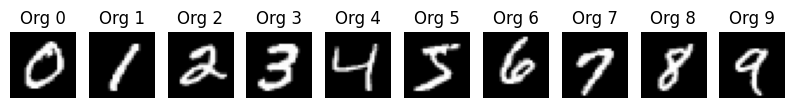

Generating synthetic datasets for l = 32
Displaying synthetic images for l = 32, dataset 1


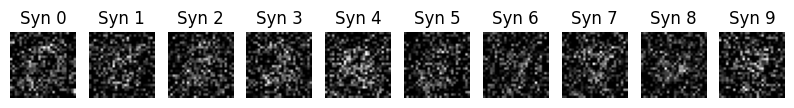

Training model on synthetic dataset 1 for l = 32
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1430 - loss: 2.2918 - val_accuracy: 0.2408 - val_loss: 2.2146
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3101 - loss: 2.1540 - val_accuracy: 0.4400 - val_loss: 2.0195
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4225 - loss: 2.0102 - val_accuracy: 0.4429 - val_loss: 1.9819
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4332 - loss: 1.9854 - val_accuracy: 0.4667 - val_loss: 1.9638
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4480 - loss: 1.9479 - val_accuracy: 0.4683 - val_loss: 1.9401
Training model on synthetic dataset 2 for l = 32
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1482 - loss: 2.2860 - val_accuracy: 0.2908 - val_loss: 2.1786
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3458 - loss: 2.1082 - val_accuracy: 0.4150 - val_loss: 2.0291
Epoch 3/5
300

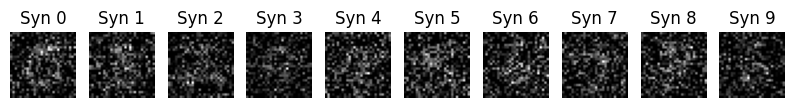

Training model on synthetic dataset 1 for l = 64
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1323 - loss: 2.2950 - val_accuracy: 0.2587 - val_loss: 2.2185
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2999 - loss: 2.1669 - val_accuracy: 0.3942 - val_loss: 2.0437
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4214 - loss: 2.0158 - val_accuracy: 0.4354 - val_loss: 1.9979
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4414 - loss: 1.9711 - val_accuracy: 0.4588 - val_loss: 1.9598
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4513 - loss: 1.9427 - val_accuracy: 0.4487 - val_loss: 1.9493
Training model on synthetic dataset 2 for l = 64
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1299 - loss: 2.2935 - val_accuracy: 0.3279 - val_loss: 2.1926
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3340 - loss: 2.1407 - val_accuracy: 0.4029 - val_loss: 2.0285
Epoch 3/5
300

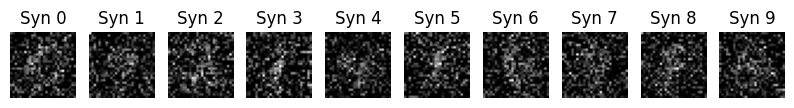

Training model on synthetic dataset 1 for l = 128
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1245 - loss: 2.2929 - val_accuracy: 0.2892 - val_loss: 2.1957
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3227 - loss: 2.1209 - val_accuracy: 0.4050 - val_loss: 2.0290
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4130 - loss: 2.0022 - val_accuracy: 0.4329 - val_loss: 2.0111
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4383 - loss: 1.9523 - val_accuracy: 0.4433 - val_loss: 1.9728
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4413 - loss: 1.9544 - val_accuracy: 0.4487 - val_loss: 1.9703
Training model on synthetic dataset 2 for l = 128
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1374 - loss: 2.2871 - val_accuracy: 0.3004 - val_loss: 2.1728
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3378 - loss: 2.1254 - val_accuracy: 0.4325 - val_loss: 2.0091
Epoch 3/5
3

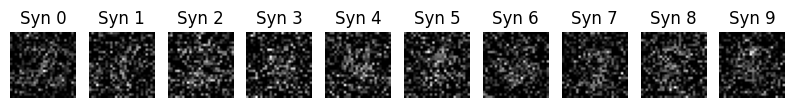

Training model on synthetic dataset 1 for l = 256
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1446 - loss: 2.2932 - val_accuracy: 0.2817 - val_loss: 2.1985
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3388 - loss: 2.1298 - val_accuracy: 0.4092 - val_loss: 2.0264
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4185 - loss: 1.9905 - val_accuracy: 0.4392 - val_loss: 1.9925
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4361 - loss: 1.9563 - val_accuracy: 0.4408 - val_loss: 1.9769
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4505 - loss: 1.9243 - val_accuracy: 0.4392 - val_loss: 1.9765
Training model on synthetic dataset 2 for l = 256
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1314 - loss: 2.2947 - val_accuracy: 0.2738 - val_loss: 2.2249
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2849 - loss: 2.1753 - val_accuracy: 0.4304 - val_loss: 2.0237
Epoch 3/5
3

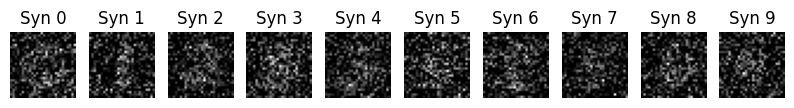

Training model on synthetic dataset 1 for l = 512
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1350 - loss: 2.2920 - val_accuracy: 0.2675 - val_loss: 2.2004
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3378 - loss: 2.1399 - val_accuracy: 0.4133 - val_loss: 1.9960
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4168 - loss: 1.9932 - val_accuracy: 0.4296 - val_loss: 1.9767
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4337 - loss: 1.9713 - val_accuracy: 0.4358 - val_loss: 1.9668
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4414 - loss: 1.9518 - val_accuracy: 0.4392 - val_loss: 1.9538
Training model on synthetic dataset 2 for l = 512
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1338 - loss: 2.2913 - val_accuracy: 0.2754 - val_loss: 2.2205
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3125 - loss: 2.1610 - val_accuracy: 0.3683 - val_loss: 2.0849
Epoch 3/5
3

In [123]:
# Display original images once
print(f"Displaying original images from MNIST dataset")
display_original_images(x_train, y_train)

# Initialize lists for accuracies
average_accuracies = []

# Loop l_values
for l in l_values:
    print(f"Generating synthetic datasets for l = {l}")
    
    # Generate 10 synthetic datasets for l
    synthetic_datasets = generate_synthetic_datasets(x_train, y_train, sigma_x, sigma_x, l, num_synthetic_samples_per_class)
    
    # Initialize a list to store test accuracies for this l
    test_accuracies_per_l = []
    
    for dataset_idx, (x_synthetic, y_synthetic) in enumerate(synthetic_datasets):
        # Display synthetic images for the first dataset
        if dataset_idx == 0:
            print(f"Displaying synthetic images for l = {l}, dataset {dataset_idx+1}")
            display_synthetic_images(x_synthetic, y_synthetic)
            
        # One-hot encode synthetic labels
        y_synthetic_one_hot = np.eye(10)[y_synthetic]

        # Split synthetic data into training and validation sets
        x_synth_train, x_synth_val, y_synth_train, y_synth_val = train_test_split(
            x_synthetic, y_synthetic_one_hot, test_size=validation_split_ratio)

        print(f"Training model on synthetic dataset {dataset_idx + 1} for l = {l}")
        
        # Build the CNN model
        model = cnn_model()
        
        # Add callbacks for early stopping and model checkpointing
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(
            f'best_modelnsU_l={l}_dataset_{dataset_idx + 1}.keras',
            save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Train the model with train/validation split
        model.fit(
            x_synth_train, y_synth_train, 
            validation_data=(x_synth_val, y_synth_val), 
            epochs=epochs, 
            verbose=1, 
            callbacks=[early_stopping, model_checkpoint]  # Include callbacks here
        )
        
        # Evaluate on original MNIST test dataset
        test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=0)
        test_accuracies_per_l.append(test_acc)
    
    
    avg_acc = np.mean(test_accuracies_per_l)
    print(f"Average test accuracy for l = {l}: {avg_acc:.4f}")
    average_accuracies.append(avg_acc)

In [124]:
# Polynomial Regression
#coefficients = np.polyfit(sigma_x_values, average_accuracies, deg=7)
#poly_fit = np.poly1d(coefficients)
#smoothed_accuracy = poly_fit(sigma_x_values)

In [125]:
# Savitzky-Golay Filter
#from scipy.signal import savgol_filter
#smooth_accuracy_filter = savgol_filter(average_accuracies, window_length=3, polyorder=0)

In [126]:
# Calculate the values of epsilon
epsilon_values = []  # To store epsilon values for each sigma_x

# Bernoulli polynomial B(l) calculation
def B(l, Delta2):
    sum_B = 0
    for i in range(l + 1):
        sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
    return sum_B

# G(alpha) calculation
def G(alpha, l, n, Delta2):
    sum_G = 0
    for j in range(3, alpha + 1):
        sum_G += (l / n)**j * comb(alpha, j) * math.sqrt(B(2 * (j // 2), Delta2) * B(2 * (j - j // 2), Delta2))
    return sum_G

# εα' calculation
def epsilon_alpha_prime(alpha, l, n, Delta2):
    min_term = min(4 * (np.exp(Delta2 / l**2) - 1), 2 * np.exp(Delta2 / l**2))
    term1 = (l / n)**2 * comb(alpha, 2) * min_term
    term2 = 4 * G(alpha, l, n, Delta2)
    return (1 / (alpha - 1)) * np.log(1 + term1 + term2)

# Final ε calculation
def epsilon(T, l, n, Delta2, delta=1/n):
    epsilons = []
    for alpha in range(2, 101): # alpha varies from 2 to 100
        try:
            epsilon_alpha = epsilon_alpha_prime(alpha, l, n, Delta2)
            epsilon_total = T * epsilon_alpha + np.log(1 / delta) / (alpha - 1)
            epsilons.append(epsilon_total)
        except (OverflowError, ValueError):
            break
    return min(epsilons)

# Loop over sigma_values to calculate epsilon for each sigma_x
for l in l_values:
    Delta2 = (dx / sigma_x**2)  +(dy / sigma_y**2)
    epsilon_value = epsilon(T, l, n, Delta2, delta)
    epsilon_values.append(epsilon_value)

C:\Users\User\AppData\Local\Temp\ipykernel_13140\3025252010.py:15: RuntimeWarning: overflow encountered in scalar multiply
  sum_G += (l / n)**j * comb(alpha, j) * math.sqrt(B(2 * (j // 2), Delta2) * B(2 * (j - j // 2), Delta2))
C:\Users\User\AppData\Local\Temp\ipykernel_13140\3025252010.py:8: RuntimeWarning: overflow encountered in exp
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_13140\3025252010.py:8: RuntimeWarning: invalid value encountered in scalar add
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_13140\3025252010.py:8: RuntimeWarning: overflow encountered in scalar multiply
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))


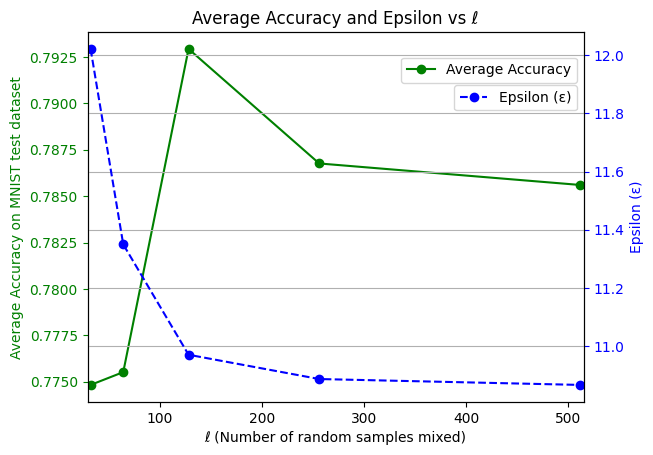

In [150]:
# Plot average accuracy vs sigma_x vs epsilon
fig, ax1 = plt.subplots()

# Plot average accuracy
ax1.plot(l_values, average_accuracies, 'go-', label='Average Accuracy')
#ax1.plot(sigma_x_values, smoothed_accuracy, 'r', label='Average Accuracy (Polynomial Regresion)')
#ax1.plot(sigma_x_values, smooth_accuracy_filter, 'm', label='Average Accuracy (Savitzky-Golay Filter)')
ax1.set_xlabel('ℓ (Number of random samples mixed)')
ax1.set_ylabel('Average Accuracy on MNIST test dataset', color='g')
ax1.tick_params('y', colors='g')

# Plot epsilon on a secondary Y-axis
ax2 = ax1.twinx()
ax2.plot(l_values, epsilon_values, 'bo--', label='Epsilon (ε)')
ax2.set_ylabel('Epsilon (ε)', color='b')
ax2.tick_params('y', colors='b')

# Collect handles and labels from both axes
#handles1, labels1 = ax1.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend using the combined handles and labels
#fig.legend(handles1 + handles2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1, 0.9))

# Add title and grid
plt.title('Average Accuracy and Epsilon vs ℓ')
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.950))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.875))
plt.grid(True)
ax1.set_xlim([29, 515]) 
plt.show()